In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
%reload_ext autoreload
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from multiprocessing import Pool

from phase_retrieval_jax import run_diffmap_algo, run_altproj_algo
from image_generator import gen_image
from register_to_reference import register_to_reference

In [29]:
n_pixels = 32
n_trials = 200
n_pad = 2


real_image, support = gen_image(
    n_pixels=n_pixels, n_pad=n_pad, k=2, n_disks=100, seed=0, supp_neigh=1
)

real_image /= np.linalg.norm(real_image)

dft_mag_img = np.abs(np.fft.fftn(real_image))

init_images = np.fft.ifft2(
    dft_mag_img[None, :, :]
    * np.exp(2j * np.pi * np.random.rand(n_trials, n_pixels * n_pad, n_pixels * n_pad))
).real

In [34]:
init_errors = np.zeros(n_trials)

for i in range(n_trials):

    triv_ass = register_to_reference(init_images[i], real_image)

    init_errors[i] = np.linalg.norm(real_image - triv_ass)

(array([ 2.,  6.,  4., 19., 24., 39., 43., 41., 18.,  4.]),
 array([0.901051  , 0.91702495, 0.93299891, 0.94897286, 0.96494681,
        0.98092076, 0.99689472, 1.01286867, 1.02884262, 1.04481658,
        1.06079053]),
 <BarContainer object of 10 artists>)

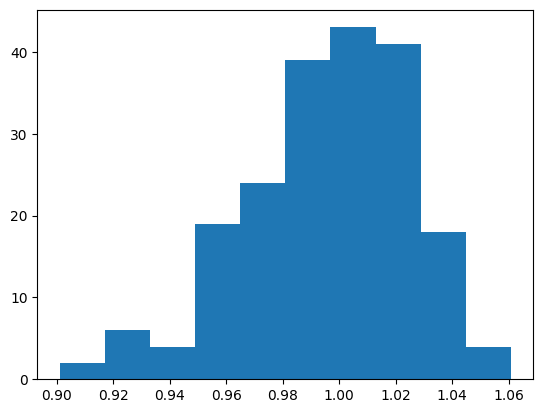

In [35]:
plt.hist(init_errors)

In [27]:
with Pool() as pool:
    results = pool.map(partial(run_diffmap_algo, n_iter=2000, exp_data=dft_mag_img, aux="supp", support_mask=support), init_images)

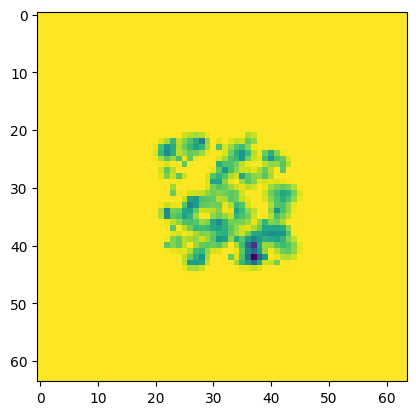

In [22]:
plt.imshow(results[3][1])

In [20]:
# warmup
run_diffmap_algo(init_image[0], 10, dft_mag_img, aux="supp", support_mask=support);

In [10]:
%time _ = run_diffmap_algo(init_image, 20000, exper_data, aux="nonneg")

CPU times: user 6.5 s, sys: 2.32 ms, total: 6.5 s
Wall time: 6.56 s


In [28]:
# actual run
# _, final_image, res = run_diffmap_algo(init_image, 1000, exper_data, support)
_, final_image, res = run_diffmap_algo(init_image, 1000, exper_data, aux="nonneg")

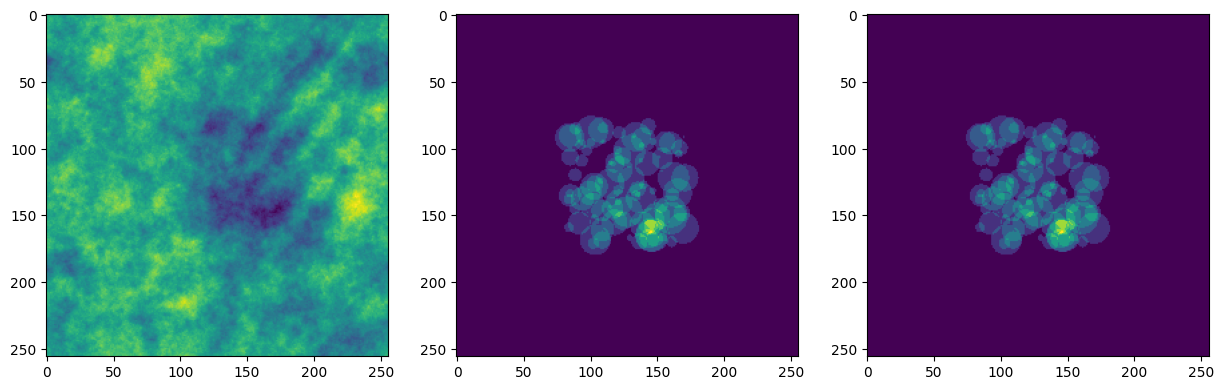

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

final_image2 = register_to_reference(final_image, real_image)

ax[0].imshow(init_image)
ax[1].imshow(final_image2, vmin=0, vmax=1)
ax[2].imshow(real_image, vmin=0, vmax=1)

In [ ]:
def solve(self, ref_data):
    real_img_famp = np.abs(np.fft.fftn(ref_data))
    final_images = np.zeros((self.config_["n_recons"], *ref_data.shape))
    recon_images = np.zeros((self.config_["n_recons"], *ref_data.shape))
    errors = np.zeros(self.config_["n_recons"])
    residuals = np.zeros((self.config_["n_recons"], self.config_["n_iter"]))

    for i in range(self.config_["n_recons"]):
        init_image_hat = real_img_famp * np.exp(
            2 * np.pi * 1j * np.random.rand(*real_img_famp.shape)
        )
        init_image = np.fft.ifftn(init_image_hat)

        final_image, recon, res = self.run_diffmap_algo(init_image)
        # recon = register_to_reference(recon, ref_data)
        errors[i] = compute_residual(recon, ref_data)
        residuals[i] = res.flatten()

        recon_images[i] = recon.reshape(*ref_data.shape)
        final_images[i] = final_image.reshape(*ref_data.shape)

    return final_images, recon_images, residuals, errors


def solve_for_animate(self, ref_data):
    np.random.seed(1)
    real_img_famp = np.abs(np.fft.fftn(ref_data))
    init_image_hat = real_img_famp * np.exp(
        2 * np.pi * 1j * np.random.rand(*real_img_famp.shape)
    )
    images = np.zeros((self.config_["n_iter"] + 1, *ref_data.shape))
    images[0] = np.fft.ifftn(init_image_hat)

    for i in range(self.config_["n_iter"]):
        images[i + 1], recon, res = self.step_diffmap_algo_(i, images[i])

    return images